In [10]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as sp
%load_ext google.cloud.bigquery
import pickle
from matplotlib import pyplot as plt
with open('design.pkl','rb') as f:
    set_params = pickle.load(f)
plt.rcParams.update(set_params)

from google.cloud import bigquery

In [11]:
# Modules
from modules.connector import MyBigQuery, MySQL

bq = MyBigQuery(
    credentials_file="./credentials/New AutoMotive Index-487e031dc242.json"
)

In [29]:
def co2ComplianceAdjFunc(row, total_trading_diff_perc):
    #checks for nan
    if row.co2Compliance > 0:
        co2Compliance = row.co2Compliance * total_trading_diff_perc
    
        return co2Compliance
    else:
        return row.co2Compliance

def co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2ComplianceAdj / 167
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    
    if new_zev_credits > 0:
        return new_zev_credits
    else:
        return 0
        
def proposed_co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    conversion_factor = row.co2Target
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2Compliance / conversion_factor
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    return new_zev_credits

In [31]:
mandate = 0.1

# Latest Compliance

In [5]:
def ft_cleaner(x):
    x = x.replace('GAS BI-FUEL', 'Other').replace('GAS', 'Other').replace('GAS DIESEL', 'Other').replace('PETROL/GAS', 'Other').replace('LPG', 'Other').replace('STEAM', 'Other').replace('LNG', 'Other').replace('OTHER', 'Other').replace('CNG', 'Other')
    x = x.replace('FUEL CELLS', 'Other')
    x = x.replace('PETROL', 'Petrol').replace('Petrol/Other', 'Petrol')
    x = x.replace('HYBRID ELECTRIC (CLEAN)', 'Hybrid').replace('HYBRID ELECTRIC', 'Hybrid').replace('ELECTRIC DIESEL', 'Hybrid')
    x = x.replace('DIESEL', 'Diesel').replace('Other Diesel', 'Diesel')
    x = x.replace('ELECTRICITY', 'Pure Electric').replace('ELECTRIC', 'Pure Electric')
    return x

In [22]:
van_targets = bq.from_bq_to_dataframe(
query = """
SELECT make, AVG(co2Emissions) as co2Target
FROM VES_dataset.VRN_UK
WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250 AND co2Emissions = 0))
AND monthOfFirstRegistration > '2020-12-31'
AND monthOfFirstRegistration < '2022-01-01'
AND co2Emissions > 0
GROUP BY make
""")

In [7]:
# %%bigquery van_targets --project rugged-baton-283921
# SELECT make, AVG(co2Emissions) as co2Target
# FROM VES_dataset.VRN_UK
# WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250 AND co2Emissions = 0))
# AND monthOfFirstRegistration > '2020-12-31'
# AND monthOfFirstRegistration < '2022-01-01'
# AND co2Emissions > 0
# GROUP BY make

In [8]:
# car_targets.sort_values('meanCo2').plot(kind='bar', x='make', figsize=(40, 10))

In [9]:
# df_activity = bq.from_bq_to_dataframe(
# query = """
# SELECT 
#     make, 
#     COUNT(*) as totalSales,
#     COUNTIF(co2Emissions > 0) as nonzevSales,
#     COUNTIF(co2Emissions = 0) as zevSales,
#     SUM(co2Emissions) as co2Activity

# FROM VES_dataset.VRN_UK
# WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250 and co2Emissions = 0))
# AND CAST(monthOfFirstRegistration AS DATE) >= '2022-05-01'
# AND CAST(monthOfFirstRegistration AS DATE) < '2023-05-01'
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
#     AND CAST(monthOfFirstRegistration AS DATE) >= '2022-05-01'
#     AND CAST(monthOfFirstRegistration AS DATE) < '2023-05-01'
#     -- AND total > 2500
#     GROUP BY make
#     HAVING COUNT(*) > 2500
# )
# GROUP BY make
# ORDER BY totalSales ASC;
# """
# )

In [10]:


df_activity = bq.from_bq_to_dataframe(
query = """
SELECT 
    make, 
    COUNT(*) as totalSales,
    COUNTIF(co2Emissions > 0) as nonzevSales,
    COUNTIF(co2Emissions = 0) as zevSales,
    SUM(co2Emissions) as co2Activity

FROM VES_dataset.VRN_UK
WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250 and co2Emissions = 0))
AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
AND make IN (
    SELECT make
    FROM VES_dataset.VRN_UK
    WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
    AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    -- AND total > 2500
    GROUP BY make
    HAVING COUNT(*) > 2500
)
GROUP BY make
ORDER BY totalSales ASC;
"""
)

In [11]:
# %%bigquery df_activity --project rugged-baton-283921
# SELECT 
#     make, 
#     COUNT(*) as totalSales,
#     COUNTIF(co2Emissions > 0) as nonzevSales,
#     COUNTIF(co2Emissions = 0) as zevSales,
#     SUM(co2Emissions) as co2Activity

# FROM VES_dataset.VRN_UK
# WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250 and co2Emissions = 0))
# AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
# AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
#     AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
#     AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
#     -- AND total > 2500
#     GROUP BY make
#     HAVING COUNT(*) > 2500
# )
# GROUP BY make
# ORDER BY totalSales ASC;

In [12]:
dfa = df_activity.merge(van_targets, how='left', on='make')
dfa['co2Allowances'] = dfa.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
dfa['co2Compliance'] = dfa.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)

In [51]:
def co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2ComplianceAdj / 167
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    
    if new_zev_credits > 0:
        return new_zev_credits
    else:
        return 0
        
def proposed_co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    conversion_factor = row.co2Target
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2Compliance / conversion_factor
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    return new_zev_credits

# def co2ComplianceAdjFunc(row, total_trading_diff_perc):
#     #checks for nan
#     if row.co2Compliance > 0:
#         co2ComplianceAdj = row.co2Compliance * total_trading_diff_perc
    
#         return co2ComplianceAdj
#     else:
#         return row.co2Compliance



In [14]:
dfa['co2_to_mandate_allowances'] = dfa.apply(lambda row: co2_to_zev(row, mandate=mandate), axis=1)
# dfa['proposed_co2_to_mandate_allowances'] = dfa.apply(lambda row: proposed_co2_to_zev(row, mandate=mandate), axis=1)


AttributeError: 'Series' object has no attribute 'co2ComplianceAdj'

In [ ]:
dfa

In [ ]:
# mandate = .1 Defined above
dfa['ZEVMallowances'] = dfa.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
dfa['ZEV Surplus'] = dfa.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
dfa['ZEV Surplus after CO2'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
# dfa['ZEV Surplus after CO2 - Proposed'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

In [ ]:
(1 - (mandate * .25)) * 135525

In [ ]:
dfa[dfa.make == 'VOLKSWAGEN']

In [ ]:
fig, ax = plt.subplots()

dfa.plot(x='make', y=[
    'ZEV Surplus', 
    'ZEV Surplus after CO2', 
    # 'ZEV Surplus after CO2 - Proposed'
], kind='barh', ax=ax, figsize=(10, 10))
ax.set_xlabel('ZEV Credit Surplus/Shortfall')
ax.set_ylabel('')

ax.set_title('How close are van manufacturers to reaching compliance')

plt.savefig('plots/van_top_20_last_12_months.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
dfa['CO2 Performance'] = dfa.co2Activity / dfa.nonzevSales

In [ ]:
dfa_sel = dfa[[
    'make',
    'totalSales',
    'nonzevSales',
    'zevSales',
    'co2Target',
    'CO2 Performance',
    'ZEVMallowances',
    'ZEV Surplus',
    'ZEV Surplus after CO2'
]].rename(columns={
    'make': 'Make',
    'totalSales': 'Total Sales',
    'co2Target': 'CO2 Target',
    'nonzevSales': 'Non-ZEV Sales',
    'zevSales': 'ZEV Sales',
    'ZEVMallowances': 'Allocated allowances',
    'ZEV Surplus': 'Allowance Surplus',
    'ZEV Surplus after CO2': 'Allowance Surplus (after CO2 transfers)'
})

# dfa_sel['Mean CO2'] = 
dfa_sel = round(dfa_sel, ndigits=2)

dfa_sel = dfa_sel.sort_values('Total Sales', ascending=False)

In [ ]:
dfa_sel.to_csv('van_ZEV_compliance_tracker.csv')

In [ ]:
dfa_sel['Allowance Surplus'].sum()

# Rolling Performance

In [13]:
%%bigquery df_act --project rugged-baton-283921
SELECT 
    VES.make,
    VES.monthOfFirstRegistration,
    COUNT(*) as totalSales,
    COUNTIF(VES.co2Emissions > 0) as nonzevSales,
    COUNTIF(VES.co2Emissions = 0) as zevSales,
    SUM(VES.co2Emissions) as co2Activity

FROM VES_dataset.VRN_UK VES
WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
AND CAST(monthOfFirstRegistration AS DATE) > '2020-03-31'
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE typeApproval = 'M1'
#     AND monthOfFirstRegistration > '2020-03-31'
#     AND monthOfFirstRegistration < '2023-04-01'
#     GROUP BY make
#     ORDER BY COUNT(*) DESC
#     LIMIT 20
    
# )

# Volume limit
AND make IN (
    SELECT make
    FROM VES_dataset.VRN_UK
    WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
    AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    -- AND total > 2500
    GROUP BY make
    HAVING COUNT(*) > 2500
)



GROUP BY make, monthofFirstRegistration
ORDER BY totalSales ASC;

Downloading: 100%|██████████| 619/619 [00:00<00:00, 1154.28rows/s]


In [14]:
df_act

,make,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity
0,LAND ROVER,2020-04-01 00:00:00+00:00,5,5,0,1010.0
1,MAXUS,2020-11-01 00:00:00+00:00,17,16,1,3488.0
2,MAXUS,2020-10-01 00:00:00+00:00,19,17,2,3706.0
3,LAND ROVER,2020-08-01 00:00:00+00:00,19,19,0,3842.0
4,MAXUS,2021-01-01 00:00:00+00:00,24,9,15,2002.0
...,...,...,...,...,...,...
614,FORD,2022-09-01 00:00:00+00:00,13061,12769,292,2785599.0
615,FORD,2023-03-01 00:00:00+00:00,15278,14837,293,3149967.0
616,FORD,2022-03-01 00:00:00+00:00,16557,16554,3,3485470.0
617,FORD,2020-09-01 00:00:00+00:00,18153,18153,0,3095417.0


In [15]:
# If we want to filter out all but the top five/ten/twenty makes, we can use this
top_makes = df_act.groupby('make').sum().sort_values('totalSales', ascending=False).index.tolist()[:10]

In [16]:
# Make a copy to edit
df = df_act.copy()#.merge(car_targets, how='left', on='make')

In [17]:
df.head()

,make,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity
0,LAND ROVER,2020-04-01 00:00:00+00:00,5,5,0,1010.0
1,MAXUS,2020-11-01 00:00:00+00:00,17,16,1,3488.0
2,MAXUS,2020-10-01 00:00:00+00:00,19,17,2,3706.0
3,LAND ROVER,2020-08-01 00:00:00+00:00,19,19,0,3842.0
4,MAXUS,2021-01-01 00:00:00+00:00,24,9,15,2002.0


In [18]:
# This turns our numbers into 12 month rolling totals/averages

dfs = []
makes = df.make.unique().tolist()

for make in makes:
    temp_df = df[df.make == make].set_index('monthOfFirstRegistration').sort_index().rolling(12).sum()
    temp_df = temp_df.reset_index().dropna()
    temp_df['make'] = make
    dfs.append(temp_df)
    
df = pd.concat(dfs)

In [19]:
df

,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity,make
11,2021-03-01 00:00:00+00:00,1407.0,1405.0,2.0,306107.0,LAND ROVER
12,2021-04-01 00:00:00+00:00,1831.0,1829.0,2.0,409892.0,LAND ROVER
13,2021-05-01 00:00:00+00:00,2098.0,2096.0,2.0,475572.0,LAND ROVER
14,2021-06-01 00:00:00+00:00,2312.0,2309.0,3.0,531843.0,LAND ROVER
15,2021-07-01 00:00:00+00:00,2446.0,2443.0,3.0,571423.0,LAND ROVER
...,...,...,...,...,...,...
34,2023-02-01 00:00:00+00:00,20153.0,17419.0,1786.0,5151159.0,MERCEDES-BENZ
35,2023-03-01 00:00:00+00:00,20433.0,17496.0,1455.0,4870243.0,MERCEDES-BENZ
36,2023-04-01 00:00:00+00:00,20524.0,17347.0,1481.0,4674285.0,MERCEDES-BENZ
37,2023-05-01 00:00:00+00:00,20755.0,17436.0,1426.0,4569519.0,MERCEDES-BENZ


In [23]:
# This gives us the targets for CO2 performance
df = df.reset_index().merge(van_targets, how='left', on='make')

In [24]:
df['co2Allowances'] = df.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
df['co2Compliance'] = df.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)

In [25]:
dfs = []

months = list(df.monthOfFirstRegistration.unique())

for month in months:
    tdf = df[df.monthOfFirstRegistration == month]
    co2_trading_demand = tdf[tdf.co2Compliance < 0].co2Compliance.sum()
    co2_trading_supply = tdf[tdf.co2Compliance > 0].co2Compliance.sum()

    co2_trading_diff = co2_trading_supply + co2_trading_demand
    co2_trading_diff_perc = co2_trading_diff / co2_trading_supply
    
    tdf['co2ComplianceAdj'] = tdf.apply(lambda row: co2ComplianceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)
    
    dfs.append(tdf)

<ipython-input-25-71e4c13204e9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['co2ComplianceAdj'] = tdf.apply(lambda row: co2ComplianceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)
<ipython-input-25-71e4c13204e9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['co2ComplianceAdj'] = tdf.apply(lambda row: co2ComplianceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)
<ipython-input-25-71e4c13204e9>:13: SettingWithCopyWarning: 
A value is tryi

In [26]:
df = pd.concat(dfs)

In [32]:

df['co2_to_mandate_allowances'] = df.apply(lambda row: co2_to_zev(row, mandate=mandate), axis=1)
# df['proposed_co2_to_mandate_allowances'] = df.apply(lambda row: proposed_co2_to_zev(row,), axis=1)

In [33]:
df.head()

,index,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity,make,co2Target,co2Allowances,co2Compliance,co2ComplianceAdj,co2_to_mandate_allowances
0,11,2021-03-01 00:00:00+00:00,1407.0,1405.0,2.0,306107.0,LAND ROVER,243.048611,3.414833e+05,35376.298611,34935.743048,35.175
51,11,2021-03-01 00:00:00+00:00,9451.0,9448.0,3.0,1754678.0,TOYOTA,220.207185,2.080517e+06,325839.482328,321781.669550,236.275
79,11,2021-03-01 00:00:00+00:00,3034.0,2932.0,101.0,1015363.0,MAN,543.085422,1.592326e+06,576963.456760,569778.294083,75.850
107,11,2021-03-01 00:00:00+00:00,12711.0,11437.0,1274.0,2018017.0,RENAULT,215.642095,2.466299e+06,448281.644605,442699.009338,317.775
135,11,2021-03-01 00:00:00+00:00,1607.0,1594.0,13.0,389459.0,RENAULT TRUCKS,504.166667,8.036417e+05,414182.666667,409024.679964,40.175


In [34]:
df['ZEVMallowances'] = df.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
df['ZEV Surplus'] = df.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
df['ZEV Surplus after CO2'] = df.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
# df['ZEV Surplus after CO2 - Proposed'] = df.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

In [35]:
df.pivot(index='monthOfFirstRegistration', columns='make', values='co2_to_mandate_allowances')

make,CITROEN,FIAT,FORD,ISUZU,IVECO,LAND ROVER,MAN,MAXUS,MERCEDES-BENZ,NISSAN,PEUGEOT,RENAULT,RENAULT TRUCKS,TOYOTA,VAUXHALL,VOLKSWAGEN
monthOfFirstRegistration,,,,,,,,,,,,,,,,
2021-03-01 00:00:00+00:00,585.150000,132.075000,2582.850000,65.50000,62.750,35.175000,75.85000,NaN,801.075000,253.125000,626.550000,317.775000,40.175,236.275000,0.000000,825.200000
2021-04-01 00:00:00+00:00,644.725000,144.525000,2815.500000,72.60000,70.100,45.775000,82.85000,NaN,840.500000,281.525000,678.325000,342.950000,43.300,263.825000,0.000000,894.300000
2021-05-01 00:00:00+00:00,701.050000,153.425000,2988.325000,78.32500,78.800,52.450000,86.45000,NaN,858.275000,304.025000,716.275000,372.175000,46.850,284.775000,0.000000,958.825000
2021-06-01 00:00:00+00:00,690.600000,157.275000,2961.550000,83.17500,89.800,57.800000,88.25000,NaN,846.775000,302.300000,725.950000,401.650000,50.325,289.575000,0.000000,994.475000
2021-07-01 00:00:00+00:00,686.075000,154.900000,2958.025000,81.75000,96.250,61.150000,87.67500,NaN,813.725000,296.150000,716.125000,386.125000,52.300,282.400000,0.000000,985.650000
2021-08-01 00:00:00+00:00,685.025000,152.475000,3038.925000,83.52500,0.000,62.900000,81.77500,0.000000,765.200000,297.825000,695.275000,378.425000,53.250,294.375000,0.000000,978.650000
2021-09-01 00:00:00+00:00,625.500000,41.446041,2876.300000,80.72500,0.000,65.675000,78.30000,0.000000,770.750000,268.375000,641.525000,381.025000,52.550,300.700000,0.000000,894.650000
2021-10-01 00:00:00+00:00,638.400000,0.000000,2925.175000,79.67500,0.000,47.670243,73.35000,0.000000,748.875000,245.534304,644.575000,389.800000,54.525,287.121739,94.595254,844.950000
2021-11-01 00:00:00+00:00,560.342576,0.000000,2582.878664,8.69759,0.000,15.588823,4.90811,0.000000,735.925000,177.130630,492.409153,259.323911,55.450,115.253871,331.159024,625.864173


In [36]:
# Are there any manufacturers failing to make Co2 compliance but with surplus ZEV credits, who would need to transfer ZEV credits into the regime 
# We assume that manufacturers would rather transfer from CO2 than purchase CO2 allowances. 
# df[(df['ZEV Surplus'] > 0) & (df.co2Compliance < 0)]

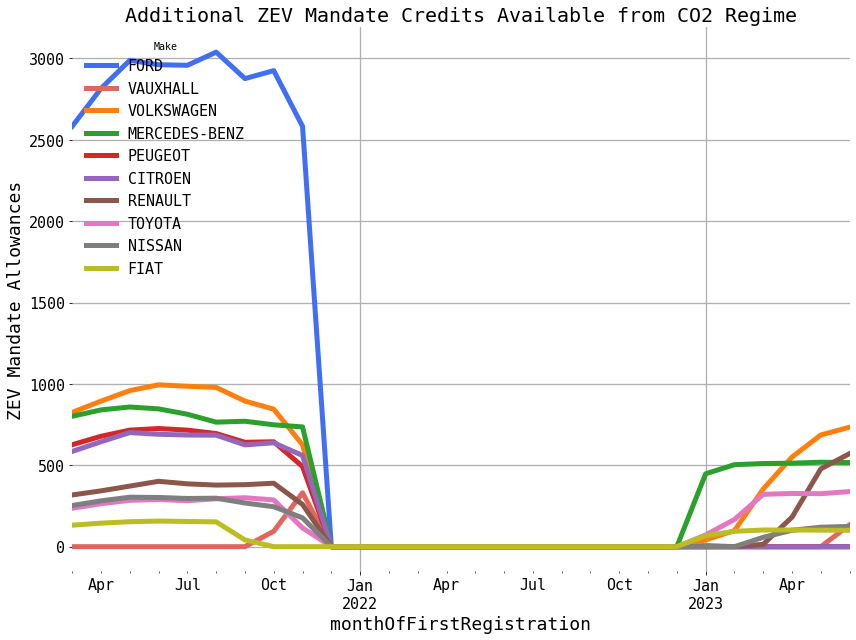

In [37]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='co2_to_mandate_allowances')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.legend(title='Make', loc='upper left')
ax.set_title('Additional ZEV Mandate Credits Available from CO2 Regime')

plt.show()

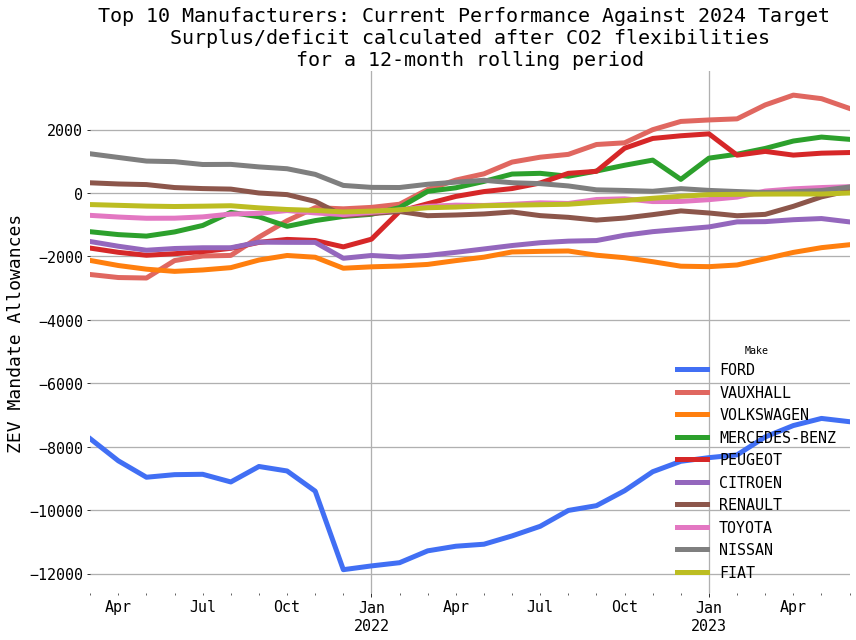

In [38]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='ZEV Surplus after CO2')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.set_xlabel('')
ax.set_title('Top 10 Manufacturers: Current Performance Against 2024 Target \n Surplus/deficit calculated after CO2 flexibilities \nfor a 12-month rolling period')
ax.legend(title='Make', loc='lower right')

# plt.savefig('plots/top_10_manufacturers_zevm.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

<AxesSubplot:xlabel='monthOfFirstRegistration'>

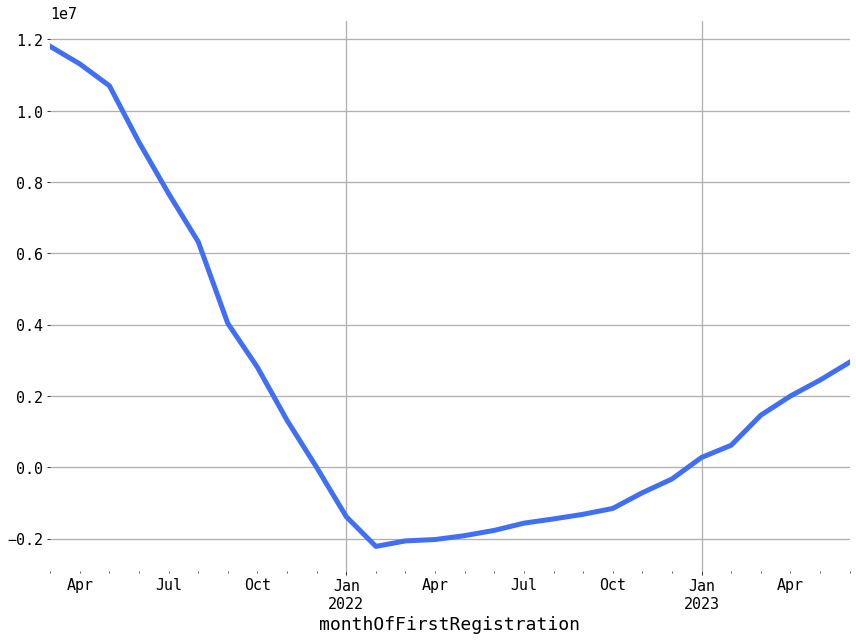

In [39]:
df.groupby(['monthOfFirstRegistration']).sum().co2Compliance.plot()

In [40]:
df

,index,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity,make,co2Target,co2Allowances,co2Compliance,co2ComplianceAdj,co2_to_mandate_allowances,ZEVMallowances,ZEV Surplus,ZEV Surplus after CO2
0,11,2021-03-01 00:00:00+00:00,1407.0,1405.0,2.0,306107.0,LAND ROVER,243.048611,3.414833e+05,3.537630e+04,3.493574e+04,35.175000,1266.3,-138.7,-103.525000
51,11,2021-03-01 00:00:00+00:00,9451.0,9448.0,3.0,1754678.0,TOYOTA,220.207185,2.080517e+06,3.258395e+05,3.217817e+05,236.275000,8505.9,-942.1,-705.825000
79,11,2021-03-01 00:00:00+00:00,3034.0,2932.0,101.0,1015363.0,MAN,543.085422,1.592326e+06,5.769635e+05,5.697783e+05,75.850000,2730.6,-201.4,-125.550000
107,11,2021-03-01 00:00:00+00:00,12711.0,11437.0,1274.0,2018017.0,RENAULT,215.642095,2.466299e+06,4.482816e+05,4.426990e+05,317.775000,11439.9,2.9,320.675000
135,11,2021-03-01 00:00:00+00:00,1607.0,1594.0,13.0,389459.0,RENAULT TRUCKS,504.166667,8.036417e+05,4.141827e+05,4.090247e+05,40.175000,1446.3,-147.7,-107.525000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,38,2023-06-01 00:00:00+00:00,29370.0,28799.0,571.0,5600780.0,VOLKSWAGEN,201.446571,5.801460e+06,2.006798e+05,1.393419e+05,734.250000,26433.0,-2366.0,-1631.750000
358,38,2023-06-01 00:00:00+00:00,20940.0,19758.0,1141.0,3709669.0,CITROEN,180.892838,3.574081e+06,-1.355883e+05,-1.355883e+05,0.000000,18846.0,-912.0,-912.000000
386,38,2023-06-01 00:00:00+00:00,27218.0,21966.0,5244.0,4143696.0,VAUXHALL,190.108867,4.175931e+06,3.223537e+04,2.238261e+04,134.027592,24496.2,2530.2,2664.227592
414,38,2023-06-01 00:00:00+00:00,101214.0,98304.0,2431.0,21047950.0,FORD,203.276392,1.998288e+07,-1.065068e+06,-1.065068e+06,0.000000,91092.6,-7211.4,-7211.400000


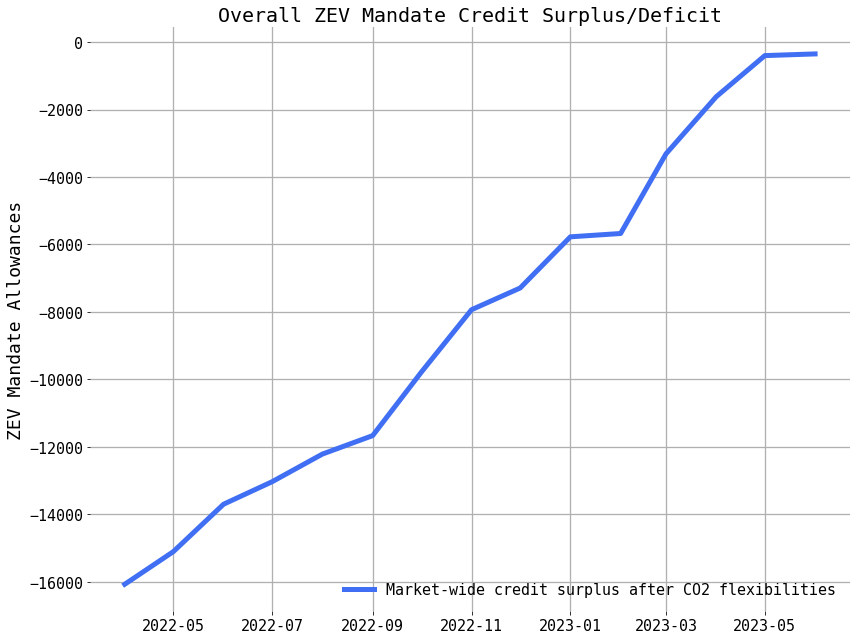

In [41]:
fig, ax = plt.subplots()

plt_df = df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2']

# ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus'], label='Market-wide credit surplus')
ax.plot(plt_df[plt_df.index > '2022-03-01'], label='Market-wide credit surplus after CO2 flexibilities')
# ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2 - Proposed'], label='Proposed Market-wide credit surplus after CO2 flexibilities')
ax.set_ylabel('ZEV Mandate Allowances')

ax.legend(loc='lower right')
ax.set_title('Overall ZEV Mandate Credit Surplus/Deficit')

plt.savefig('plots/van_aggregate_demand_credits.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [42]:
df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2']

monthOfFirstRegistration
2021-03-01 00:00:00+00:00   -17148.175000
2021-04-01 00:00:00+00:00   -18806.100000
2021-05-01 00:00:00+00:00   -19993.075000
2021-06-01 00:00:00+00:00   -19391.900000
2021-07-01 00:00:00+00:00   -18999.000000
2021-08-01 00:00:00+00:00   -18134.075000
2021-09-01 00:00:00+00:00   -16732.678959
2021-10-01 00:00:00+00:00   -16391.753461
2021-11-01 00:00:00+00:00   -16877.268474
2021-12-01 00:00:00+00:00   -21337.100000
2022-01-01 00:00:00+00:00   -20601.100000
2022-02-01 00:00:00+00:00   -19140.300000
2022-03-01 00:00:00+00:00   -17286.200000
2022-04-01 00:00:00+00:00   -16071.800000
2022-05-01 00:00:00+00:00   -15104.100000
2022-06-01 00:00:00+00:00   -13698.600000
2022-07-01 00:00:00+00:00   -13031.000000
2022-08-01 00:00:00+00:00   -12212.200000
2022-09-01 00:00:00+00:00   -11665.600000
2022-10-01 00:00:00+00:00    -9786.200000
2022-11-01 00:00:00+00:00    -7934.200000
2022-12-01 00:00:00+00:00    -7290.500000
2023-01-01 00:00:00+00:00    -5773.850010
2023-02-0

In [43]:
df.columns = [x.replace(' ', '') for x in df.columns]

In [44]:
client = bigquery.Client()
table_id = 'zevMandate.vanRollingPerformance'

job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField('monthOfFirstRegistration', 'DATE'),
        bigquery.SchemaField('make', 'STRING'),
        bigquery.SchemaField('totalSales', 'INTEGER'),
        bigquery.SchemaField('nonzevSales', 'INTEGER'),
        bigquery.SchemaField('zevSales', 'INTEGER'),
        bigquery.SchemaField('co2Activity', 'FLOAT'),
        bigquery.SchemaField('co2Target', 'FLOAT'),
        bigquery.SchemaField('co2Allowances', 'FLOAT'),
        bigquery.SchemaField('co2Compliance', 'FLOAT'),
        bigquery.SchemaField('co2ComplianceAdj', 'FLOAT'),
        bigquery.SchemaField('ZEVMallowances', 'FLOAT'),
        bigquery.SchemaField('ZEVSurplus', 'FLOAT'),
        bigquery.SchemaField('co2_to_mandate_allowances', 'FLOAT'),
        bigquery.SchemaField('ZEVSurplusafterCO2', 'FLOAT')
        
    ]
)
job_config.write_disposition = 'WRITE_TRUNCATE'
job = client.load_table_from_dataframe(df, table_id, job_config=job_config)

job.result()

In [25]:
df['meanCo2'] = df.apply(lambda row: row.co2Activity / row.nonzevSales if row.nonzevSales >0 else np.nan , axis=1)

NameError: name 'df' is not defined

In [26]:
van_targets[van_targets.make.isin(top_makes)]

NameError: name 'top_makes' is not defined

NameError: name 'df' is not defined

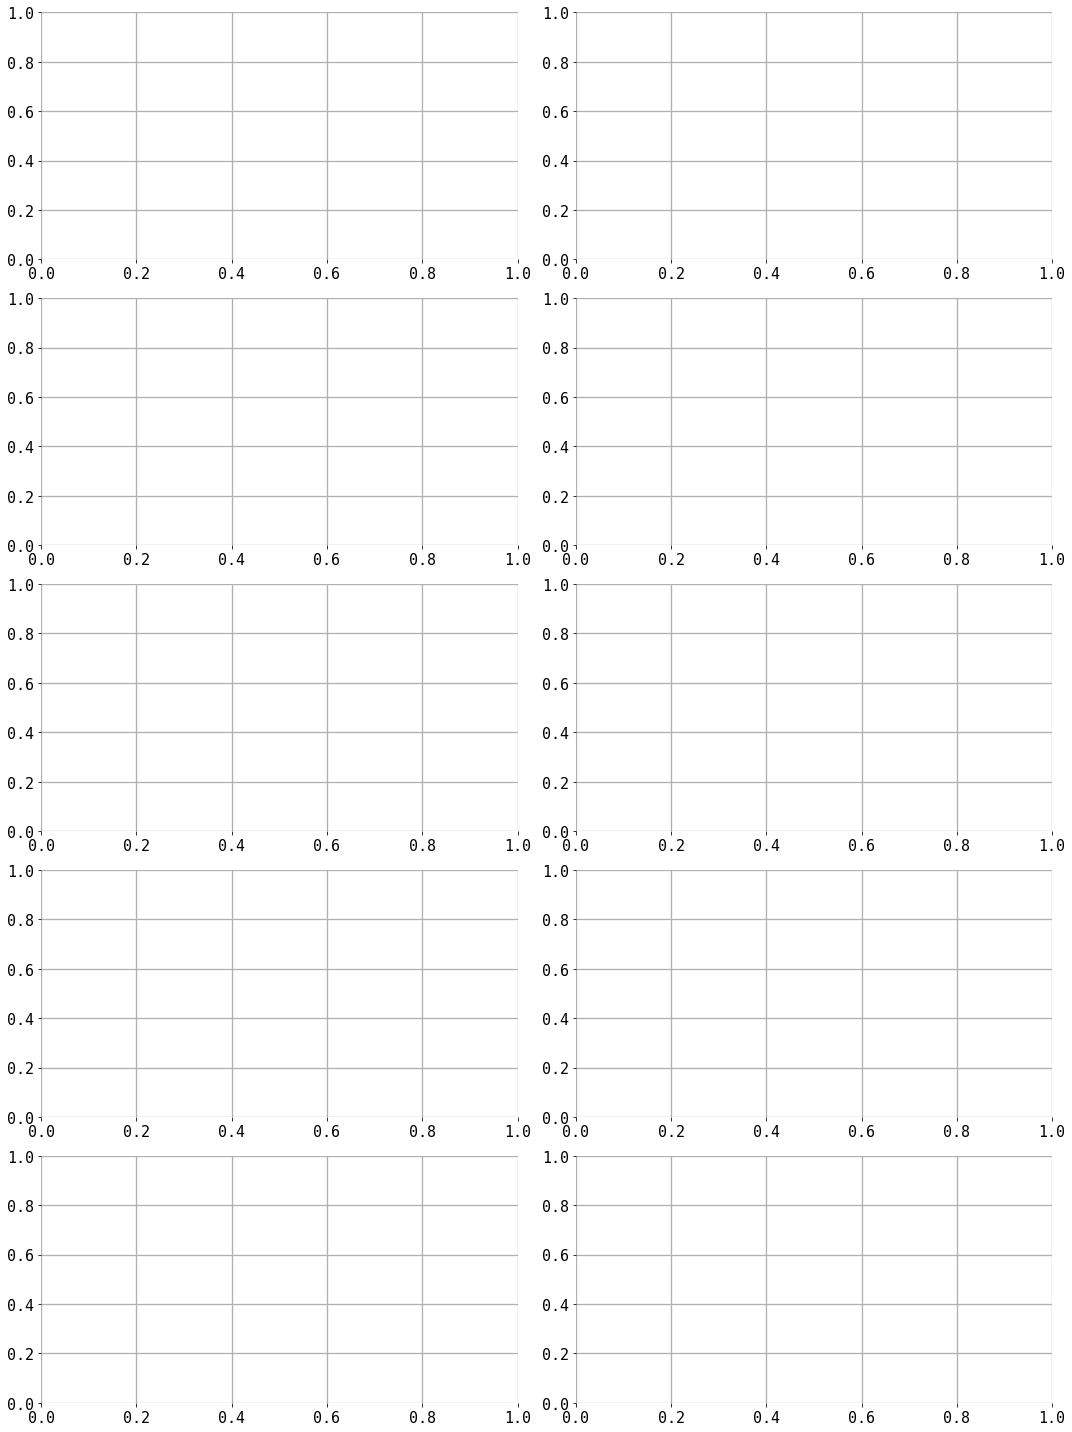

In [27]:
fig, ax = plt.subplots(5, 2, figsize=(15, 20))

# # df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes].plot(ax=ax)
# # ax.axhline(car_targets[car_targets.make.isin(top_makes)])
# # ax.set_xlabel('')
# # ax.legend(title='Make', loc='lower right')

plt_df = df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes]



for e, make in enumerate(top_makes[:5]):
    ax[e, 0].plot(plt_df[make], c='red')
    ax[e, 0].axhline(van_targets[van_targets.make == make].co2Target.values, c='black', linestyle='--')
    ax[e, 0].set_title(make)
    ax[e, 0].figure.autofmt_xdate()
    # ax[e, 0].set_ylabel('Mean WLPT CO2g/km')
    
for e, make in enumerate(top_makes[5:]):
    ax[e, 1].plot(plt_df[make], c='red')
    ax[e, 1].axhline(van_targets[van_targets.make == make].co2Target.values, c='black', label='2021 Baseline Target', linestyle='--')
    ax[e, 1].set_title(make)
    ax[e, 1].figure.autofmt_xdate()
    # ax[e, 1].set_ylabel('Mean WLPT CO2g/km')
    

fig.text(0.0, 0.5, 'Mean WLTP CO2g/km', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Top 20 Manufacturers: Car CO2 performance against 2021 average \n 12-month rolling average', y=1, fontsize=25)
fig.tight_layout()
# plt.show()

plt.savefig('plots/van_co2.png', transparent=False, bbox_inches='tight', dpi=300)

# ax[0, 0]

In [ ]:
df